In [1]:
#load pacakges
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models, datasets
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import time
from utils_jnb import *
import torchattacks
import torchvision
torch.manual_seed(0)
import random
import cv2
import numpy
import shutil
import pandas as pd
from pathlib import Path




In [2]:
# Note you need to replace src with the original data when rerunning from the top

In [3]:
random.seed(10)


torch.cuda.empty_cache()
set_global_seed()

###  Generate Patch

#### Train Model and apply PGD

In [9]:
num_classes = 2

resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the last layer
resnet50.fc = nn.Sequential(nn.Linear(2048, 512),
                             nn.ReLU(),
                             nn.Dropout(0.4),
                             nn.Linear(512, num_classes),
                             nn.LogSoftmax(dim=1))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
directory = "./src"
model=resnet50
# Define Optimizer and Loss Function
lossFunc = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=1e-2) #https://arxiv.org/pdf/1908.03265.pdf

# Decay LR by a factor of 0.1 every 7 epochs
expLrScheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
summary(model, input_size=(3, 224, 224), batch_size=32)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

In [12]:
history = trainValid(model, lossFunc, optimizer, epochs=10)

[3290, 366]
3656
Epoch: 1/10
Batch number: 000, Training: Loss: 0.6677, Accuracy: 0.5938
Batch number: 001, Training: Loss: 0.5916, Accuracy: 0.6562
Batch number: 002, Training: Loss: 0.5810, Accuracy: 0.6875
Batch number: 003, Training: Loss: 0.5314, Accuracy: 0.6875
Batch number: 004, Training: Loss: 0.6461, Accuracy: 0.5938
Batch number: 005, Training: Loss: 0.6268, Accuracy: 0.6250
Batch number: 006, Training: Loss: 0.4560, Accuracy: 0.7500
Batch number: 007, Training: Loss: 0.3809, Accuracy: 0.8438
Batch number: 008, Training: Loss: 0.3984, Accuracy: 0.8750
Batch number: 009, Training: Loss: 0.4065, Accuracy: 0.8750
Batch number: 010, Training: Loss: 0.3829, Accuracy: 0.8750
Batch number: 011, Training: Loss: 0.3154, Accuracy: 0.9375
Batch number: 012, Training: Loss: 0.5257, Accuracy: 0.7188
Batch number: 013, Training: Loss: 0.2315, Accuracy: 0.9062
Batch number: 014, Training: Loss: 0.3625, Accuracy: 0.7812
Batch number: 015, Training: Loss: 0.2524, Accuracy: 0.9375
Batch numbe

Validation Batch number: 030, Validation: Loss: 0.0883, Accuracy: 1.0000
Validation Batch number: 031, Validation: Loss: 0.0630, Accuracy: 1.0000
Validation Batch number: 032, Validation: Loss: 0.0431, Accuracy: 1.0000
Validation Batch number: 033, Validation: Loss: 0.1331, Accuracy: 1.0000
Validation Batch number: 034, Validation: Loss: 0.2246, Accuracy: 1.0000
Validation Batch number: 035, Validation: Loss: 0.0745, Accuracy: 1.0000
Validation Batch number: 036, Validation: Loss: 0.1305, Accuracy: 1.0000
Validation Batch number: 037, Validation: Loss: 0.0197, Accuracy: 1.0000
Validation Batch number: 038, Validation: Loss: 0.0601, Accuracy: 1.0000
Validation Batch number: 039, Validation: Loss: 0.4544, Accuracy: 0.7500
Validation Batch number: 040, Validation: Loss: 0.6499, Accuracy: 0.7500
Validation Batch number: 041, Validation: Loss: 0.0886, Accuracy: 1.0000
Validation Batch number: 042, Validation: Loss: 0.3047, Accuracy: 0.7500
Validation Batch number: 043, Validation: Loss: 0.0

Batch number: 059, Training: Loss: 0.3430, Accuracy: 0.8750
Batch number: 060, Training: Loss: 0.3265, Accuracy: 0.8125
Batch number: 061, Training: Loss: 0.2325, Accuracy: 0.8750
Batch number: 062, Training: Loss: 0.2781, Accuracy: 0.8438
Batch number: 063, Training: Loss: 0.1905, Accuracy: 0.9062
Batch number: 064, Training: Loss: 0.1049, Accuracy: 0.9375
Batch number: 065, Training: Loss: 0.1124, Accuracy: 0.9688
Batch number: 066, Training: Loss: 0.3820, Accuracy: 0.9062
Batch number: 067, Training: Loss: 0.5488, Accuracy: 0.8438
Batch number: 068, Training: Loss: 0.4366, Accuracy: 0.8438
Batch number: 069, Training: Loss: 0.1768, Accuracy: 0.9375
Batch number: 070, Training: Loss: 0.5023, Accuracy: 0.7812
Batch number: 071, Training: Loss: 0.5012, Accuracy: 0.7812
Batch number: 072, Training: Loss: 0.1898, Accuracy: 0.9062
Batch number: 073, Training: Loss: 0.3351, Accuracy: 0.9062
Batch number: 074, Training: Loss: 0.1174, Accuracy: 0.9688
Batch number: 075, Training: Loss: 0.089

Validation Batch number: 077, Validation: Loss: 0.4149, Accuracy: 0.7500
Validation Batch number: 078, Validation: Loss: 0.4449, Accuracy: 0.5000
Validation Batch number: 079, Validation: Loss: 0.0996, Accuracy: 1.0000
Validation Batch number: 080, Validation: Loss: 0.0605, Accuracy: 1.0000
Validation Batch number: 081, Validation: Loss: 0.0590, Accuracy: 1.0000
Validation Batch number: 082, Validation: Loss: 0.1464, Accuracy: 1.0000
Validation Batch number: 083, Validation: Loss: 0.0316, Accuracy: 1.0000
Validation Batch number: 084, Validation: Loss: 0.0457, Accuracy: 1.0000
Validation Batch number: 085, Validation: Loss: 0.2565, Accuracy: 0.7500
Validation Batch number: 086, Validation: Loss: 0.2507, Accuracy: 1.0000
Validation Batch number: 087, Validation: Loss: 0.1703, Accuracy: 1.0000
Validation Batch number: 088, Validation: Loss: 0.0138, Accuracy: 1.0000
Validation Batch number: 089, Validation: Loss: 0.0860, Accuracy: 1.0000
Validation Batch number: 090, Validation: Loss: 0.2

Validation Batch number: 012, Validation: Loss: 0.0138, Accuracy: 1.0000
Validation Batch number: 013, Validation: Loss: 0.0737, Accuracy: 1.0000
Validation Batch number: 014, Validation: Loss: 0.0854, Accuracy: 1.0000
Validation Batch number: 015, Validation: Loss: 0.1156, Accuracy: 1.0000
Validation Batch number: 016, Validation: Loss: 0.1037, Accuracy: 1.0000
Validation Batch number: 017, Validation: Loss: 0.1752, Accuracy: 1.0000
Validation Batch number: 018, Validation: Loss: 0.4509, Accuracy: 0.7500
Validation Batch number: 019, Validation: Loss: 0.2034, Accuracy: 1.0000
Validation Batch number: 020, Validation: Loss: 0.0381, Accuracy: 1.0000
Validation Batch number: 021, Validation: Loss: 0.3310, Accuracy: 0.7500
Validation Batch number: 022, Validation: Loss: 0.0665, Accuracy: 1.0000
Validation Batch number: 023, Validation: Loss: 0.0517, Accuracy: 1.0000
Validation Batch number: 024, Validation: Loss: 0.1224, Accuracy: 1.0000
Validation Batch number: 025, Validation: Loss: 0.2

Batch number: 037, Training: Loss: 0.2219, Accuracy: 0.9062
Batch number: 038, Training: Loss: 0.1391, Accuracy: 0.9375
Batch number: 039, Training: Loss: 0.3870, Accuracy: 0.8125
Batch number: 040, Training: Loss: 0.2413, Accuracy: 0.9062
Batch number: 041, Training: Loss: 0.0973, Accuracy: 0.9688
Batch number: 042, Training: Loss: 0.2241, Accuracy: 0.9062
Batch number: 043, Training: Loss: 0.4977, Accuracy: 0.8750
Batch number: 044, Training: Loss: 0.1830, Accuracy: 0.9062
Batch number: 045, Training: Loss: 0.3065, Accuracy: 0.8750
Batch number: 046, Training: Loss: 0.3466, Accuracy: 0.8125
Batch number: 047, Training: Loss: 0.1709, Accuracy: 0.9688
Batch number: 048, Training: Loss: 0.2274, Accuracy: 0.9062
Batch number: 049, Training: Loss: 0.3544, Accuracy: 0.7812
Batch number: 050, Training: Loss: 0.2091, Accuracy: 0.9062
Batch number: 051, Training: Loss: 0.1912, Accuracy: 0.9062
Batch number: 052, Training: Loss: 0.3123, Accuracy: 0.8438
Batch number: 053, Training: Loss: 0.185

Validation Batch number: 059, Validation: Loss: 0.1315, Accuracy: 1.0000
Validation Batch number: 060, Validation: Loss: 0.0171, Accuracy: 1.0000
Validation Batch number: 061, Validation: Loss: 0.0313, Accuracy: 1.0000
Validation Batch number: 062, Validation: Loss: 0.0872, Accuracy: 1.0000
Validation Batch number: 063, Validation: Loss: 0.0801, Accuracy: 1.0000
Validation Batch number: 064, Validation: Loss: 0.0661, Accuracy: 1.0000
Validation Batch number: 065, Validation: Loss: 0.0934, Accuracy: 1.0000
Validation Batch number: 066, Validation: Loss: 0.0391, Accuracy: 1.0000
Validation Batch number: 067, Validation: Loss: 0.1782, Accuracy: 1.0000
Validation Batch number: 068, Validation: Loss: 0.2131, Accuracy: 1.0000
Validation Batch number: 069, Validation: Loss: 0.1960, Accuracy: 1.0000
Validation Batch number: 070, Validation: Loss: 0.0698, Accuracy: 1.0000
Validation Batch number: 071, Validation: Loss: 0.0287, Accuracy: 1.0000
Validation Batch number: 072, Validation: Loss: 0.2

Batch number: 095, Training: Loss: 0.4254, Accuracy: 0.8438
Batch number: 096, Training: Loss: 0.2580, Accuracy: 0.9062
Batch number: 097, Training: Loss: 0.3998, Accuracy: 0.8438
Batch number: 098, Training: Loss: 0.2004, Accuracy: 0.8750
Batch number: 099, Training: Loss: 0.2218, Accuracy: 0.9062
Batch number: 100, Training: Loss: 0.2473, Accuracy: 0.8750
Batch number: 101, Training: Loss: 0.1752, Accuracy: 0.9375
Validation Batch number: 000, Validation: Loss: 0.5729, Accuracy: 0.7500
Validation Batch number: 001, Validation: Loss: 0.2345, Accuracy: 0.7500
Validation Batch number: 002, Validation: Loss: 0.4257, Accuracy: 1.0000
Validation Batch number: 003, Validation: Loss: 0.0553, Accuracy: 1.0000
Validation Batch number: 004, Validation: Loss: 0.0048, Accuracy: 1.0000
Validation Batch number: 005, Validation: Loss: 0.1442, Accuracy: 1.0000
Validation Batch number: 006, Validation: Loss: 0.2554, Accuracy: 0.7500
Validation Batch number: 007, Validation: Loss: 0.1646, Accuracy: 1.0

Batch number: 016, Training: Loss: 0.1441, Accuracy: 0.9688
Batch number: 017, Training: Loss: 0.2442, Accuracy: 0.8750
Batch number: 018, Training: Loss: 0.1643, Accuracy: 0.9688
Batch number: 019, Training: Loss: 0.3652, Accuracy: 0.7500
Batch number: 020, Training: Loss: 0.2633, Accuracy: 0.8750
Batch number: 021, Training: Loss: 0.2311, Accuracy: 0.9062
Batch number: 022, Training: Loss: 0.1902, Accuracy: 0.8750
Batch number: 023, Training: Loss: 0.3096, Accuracy: 0.9062
Batch number: 024, Training: Loss: 0.4414, Accuracy: 0.8438
Batch number: 025, Training: Loss: 0.3690, Accuracy: 0.8750
Batch number: 026, Training: Loss: 0.1523, Accuracy: 0.9062
Batch number: 027, Training: Loss: 0.2282, Accuracy: 0.9062
Batch number: 028, Training: Loss: 0.1633, Accuracy: 0.9062
Batch number: 029, Training: Loss: 0.1502, Accuracy: 0.9375
Batch number: 030, Training: Loss: 0.3026, Accuracy: 0.8438
Batch number: 031, Training: Loss: 0.2190, Accuracy: 0.9062
Batch number: 032, Training: Loss: 0.459

Validation Batch number: 043, Validation: Loss: 0.0009, Accuracy: 1.0000
Validation Batch number: 044, Validation: Loss: 0.0400, Accuracy: 1.0000
Validation Batch number: 045, Validation: Loss: 0.0776, Accuracy: 1.0000
Validation Batch number: 046, Validation: Loss: 0.6752, Accuracy: 0.5000
Validation Batch number: 047, Validation: Loss: 0.0540, Accuracy: 1.0000
Validation Batch number: 048, Validation: Loss: 0.2587, Accuracy: 1.0000
Validation Batch number: 049, Validation: Loss: 0.4215, Accuracy: 0.7500
Validation Batch number: 050, Validation: Loss: 0.2310, Accuracy: 1.0000
Validation Batch number: 051, Validation: Loss: 0.5210, Accuracy: 0.7500
Validation Batch number: 052, Validation: Loss: 0.2181, Accuracy: 0.7500
Validation Batch number: 053, Validation: Loss: 0.1907, Accuracy: 1.0000
Validation Batch number: 054, Validation: Loss: 0.1681, Accuracy: 1.0000
Validation Batch number: 055, Validation: Loss: 0.0233, Accuracy: 1.0000
Validation Batch number: 056, Validation: Loss: 0.0

Batch number: 076, Training: Loss: 0.2341, Accuracy: 0.9062
Batch number: 077, Training: Loss: 0.1770, Accuracy: 0.9062
Batch number: 078, Training: Loss: 0.2731, Accuracy: 0.7812
Batch number: 079, Training: Loss: 0.2080, Accuracy: 0.8750
Batch number: 080, Training: Loss: 0.1391, Accuracy: 0.9062
Batch number: 081, Training: Loss: 0.3026, Accuracy: 0.8438
Batch number: 082, Training: Loss: 0.5290, Accuracy: 0.8438
Batch number: 083, Training: Loss: 0.1931, Accuracy: 0.8438
Batch number: 084, Training: Loss: 0.4526, Accuracy: 0.7812
Batch number: 085, Training: Loss: 0.3530, Accuracy: 0.8438
Batch number: 086, Training: Loss: 0.1997, Accuracy: 0.9375
Batch number: 087, Training: Loss: 0.1936, Accuracy: 0.9062
Batch number: 088, Training: Loss: 0.2336, Accuracy: 0.8750
Batch number: 089, Training: Loss: 0.2479, Accuracy: 0.8438
Batch number: 090, Training: Loss: 0.1385, Accuracy: 0.9688
Batch number: 091, Training: Loss: 0.2070, Accuracy: 0.9062
Batch number: 092, Training: Loss: 0.243

Epoch : 006, Training: Loss : 0.2524, Accuracy: 88.5106%
Validation : Loss : 0.1879, Accuracy: 90.9836%, Time: 48.8280s
Best accuracy achieved so far : 0.9290 on epoch 2
Epoch: 8/10
Batch number: 000, Training: Loss: 0.2373, Accuracy: 0.9688
Batch number: 001, Training: Loss: 0.3570, Accuracy: 0.8438
Batch number: 002, Training: Loss: 0.3123, Accuracy: 0.8438
Batch number: 003, Training: Loss: 0.2753, Accuracy: 0.8750
Batch number: 004, Training: Loss: 0.2823, Accuracy: 0.8438
Batch number: 005, Training: Loss: 0.2740, Accuracy: 0.8750
Batch number: 006, Training: Loss: 0.3463, Accuracy: 0.7812
Batch number: 007, Training: Loss: 0.2565, Accuracy: 0.9062
Batch number: 008, Training: Loss: 0.2149, Accuracy: 0.9062
Batch number: 009, Training: Loss: 0.2268, Accuracy: 0.8125
Batch number: 010, Training: Loss: 0.3247, Accuracy: 0.8750
Batch number: 011, Training: Loss: 0.3512, Accuracy: 0.9062
Batch number: 012, Training: Loss: 1.0030, Accuracy: 0.7188
Batch number: 013, Training: Loss: 0.2

Validation Batch number: 027, Validation: Loss: 0.0041, Accuracy: 1.0000
Validation Batch number: 028, Validation: Loss: 0.0029, Accuracy: 1.0000
Validation Batch number: 029, Validation: Loss: 0.3898, Accuracy: 0.7500
Validation Batch number: 030, Validation: Loss: 0.0029, Accuracy: 1.0000
Validation Batch number: 031, Validation: Loss: 0.0648, Accuracy: 1.0000
Validation Batch number: 032, Validation: Loss: 0.0079, Accuracy: 1.0000
Validation Batch number: 033, Validation: Loss: 0.0970, Accuracy: 1.0000
Validation Batch number: 034, Validation: Loss: 0.5193, Accuracy: 0.7500
Validation Batch number: 035, Validation: Loss: 0.1843, Accuracy: 1.0000
Validation Batch number: 036, Validation: Loss: 0.1342, Accuracy: 1.0000
Validation Batch number: 037, Validation: Loss: 0.0062, Accuracy: 1.0000
Validation Batch number: 038, Validation: Loss: 0.0340, Accuracy: 1.0000
Validation Batch number: 039, Validation: Loss: 0.2930, Accuracy: 0.7500
Validation Batch number: 040, Validation: Loss: 0.9

Batch number: 056, Training: Loss: 0.1935, Accuracy: 0.8750
Batch number: 057, Training: Loss: 0.2722, Accuracy: 0.8125
Batch number: 058, Training: Loss: 0.1511, Accuracy: 0.9062
Batch number: 059, Training: Loss: 0.1919, Accuracy: 0.8750
Batch number: 060, Training: Loss: 0.3298, Accuracy: 0.7812
Batch number: 061, Training: Loss: 0.3250, Accuracy: 0.8438
Batch number: 062, Training: Loss: 0.2620, Accuracy: 0.8750
Batch number: 063, Training: Loss: 0.2211, Accuracy: 0.8438
Batch number: 064, Training: Loss: 0.1951, Accuracy: 0.9375
Batch number: 065, Training: Loss: 0.1462, Accuracy: 0.9688
Batch number: 066, Training: Loss: 0.1662, Accuracy: 0.9375
Batch number: 067, Training: Loss: 0.3139, Accuracy: 0.7812
Batch number: 068, Training: Loss: 0.3451, Accuracy: 0.8125
Batch number: 069, Training: Loss: 0.2430, Accuracy: 0.8438
Batch number: 070, Training: Loss: 0.4981, Accuracy: 0.8750
Batch number: 071, Training: Loss: 0.2372, Accuracy: 0.9062
Batch number: 072, Training: Loss: 0.198

Validation Batch number: 075, Validation: Loss: 0.3035, Accuracy: 0.7500
Validation Batch number: 076, Validation: Loss: 0.2712, Accuracy: 0.7500
Validation Batch number: 077, Validation: Loss: 0.2735, Accuracy: 0.7500
Validation Batch number: 078, Validation: Loss: 0.5548, Accuracy: 0.7500
Validation Batch number: 079, Validation: Loss: 0.3450, Accuracy: 0.7500
Validation Batch number: 080, Validation: Loss: 0.0111, Accuracy: 1.0000
Validation Batch number: 081, Validation: Loss: 0.0053, Accuracy: 1.0000
Validation Batch number: 082, Validation: Loss: 0.1461, Accuracy: 1.0000
Validation Batch number: 083, Validation: Loss: 0.0739, Accuracy: 1.0000
Validation Batch number: 084, Validation: Loss: 0.0184, Accuracy: 1.0000
Validation Batch number: 085, Validation: Loss: 0.0561, Accuracy: 1.0000
Validation Batch number: 086, Validation: Loss: 0.0455, Accuracy: 1.0000
Validation Batch number: 087, Validation: Loss: 0.2408, Accuracy: 0.7500
Validation Batch number: 088, Validation: Loss: 0.0

Validation Batch number: 011, Validation: Loss: 0.0128, Accuracy: 1.0000
Validation Batch number: 012, Validation: Loss: 0.0055, Accuracy: 1.0000
Validation Batch number: 013, Validation: Loss: 0.1092, Accuracy: 1.0000
Validation Batch number: 014, Validation: Loss: 0.1395, Accuracy: 1.0000
Validation Batch number: 015, Validation: Loss: 0.1486, Accuracy: 1.0000
Validation Batch number: 016, Validation: Loss: 0.1238, Accuracy: 1.0000
Validation Batch number: 017, Validation: Loss: 0.0319, Accuracy: 1.0000
Validation Batch number: 018, Validation: Loss: 1.1889, Accuracy: 0.7500
Validation Batch number: 019, Validation: Loss: 0.3196, Accuracy: 1.0000
Validation Batch number: 020, Validation: Loss: 0.0089, Accuracy: 1.0000
Validation Batch number: 021, Validation: Loss: 0.3279, Accuracy: 1.0000
Validation Batch number: 022, Validation: Loss: 0.0433, Accuracy: 1.0000
Validation Batch number: 023, Validation: Loss: 0.0175, Accuracy: 1.0000
Validation Batch number: 024, Validation: Loss: 0.0

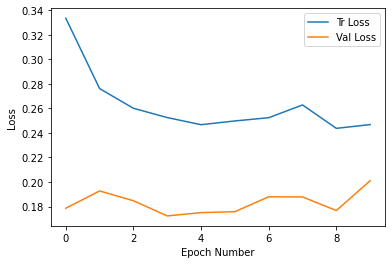

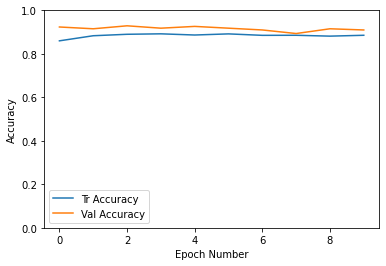

Test accuracy : 0.9103671706263499
Test loss : 0.2209175834320669


(0.9103671706263499, 0.2209175834320669)

In [13]:
plotCost(history)
#saved_model = torch.load('src_model_best_shang.pt')
saved_model = torch.load('src_model_2.pt')
computeTestSetAccuracy(saved_model, lossFunc)

#### Generate Patch    

[3290, 366]
3656
[3290, 366]
3656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class probability: tensor(1., device='cuda:0')


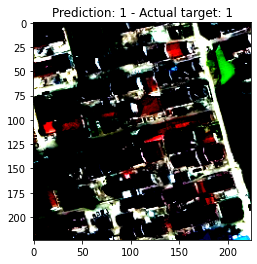

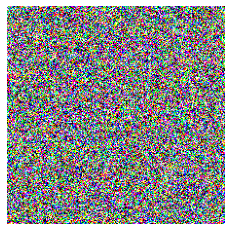

In [14]:
#load model and demonstrate that it classifies a building image correctly
idx=1
try:
    saved_model = torch.load('src_model_2.pt')
except:
    saved_model = torch.load('src_model_2.pt',map_location=torch.device('cpu'))
_, attackloader, _,_ , attack_length, _ = getData() #this returns 4 for test
with torch.no_grad():
    for j, (inputs, labels) in enumerate(attackloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

try:
    saved_model = torch.load('src_model_best_shang.pt')
except:
    saved_model = torch.load('src_model_best_shang.pt',map_location=torch.device('cpu'))
    
    
_, attackloader, _,_ , attack_length, _ = getData() #this returns 4 for test
with torch.no_grad():
    for j, (inputs, labels) in enumerate(attackloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
with torch.no_grad():
    
    image=inputs[idx]
    #inputs, labels = inputs.cuda(), labels.cuda() 
    #image=image.cpu()
    
    # Generate prediction
    prediction = saved_model(image.unsqueeze(0))

    # Predicted class value using argmax
    predicted_class = np.argmax(prediction.cpu())
    print("Class probability: " +str(torch.max(nnf.softmax(prediction, dim=1))))

    # Reshape image

    image=image.cpu()
    image=image.swapaxes(0,1)
    image=image.swapaxes(1,2)

    # Show result
    plt.imshow(image.cpu(), cmap='Spectral')
    plt.title(f'Prediction: {predicted_class} - Actual target: '+str(labels[idx].detach().cpu().numpy()))
    plt.show()


#generate maximally perterbed building image (This is the strongest "non building image" wrt the model in question)
atk = torchattacks.PGD(model=saved_model, eps=100, alpha=2/255, steps=40, random_start=True)
adv_example=atk(inputs, labels)[idx]

with torch.no_grad():

    prediction = saved_model(adv_example.unsqueeze(0))

    predicted_class = np.argmax(prediction.cpu())
    #print("Class probability: " +str(torch.max(nnf.softmax(prediction, dim=1))))

    # Reshape image

    adv_example=adv_example.cpu()
    adv_example=adv_example.swapaxes(0,1)
    adv_example=adv_example.swapaxes(1,2)

    # Show result
    plt.imshow(adv_example.cpu(), cmap='nipy_spectral')
    #plt.title(f'Prediction: {predicted_class} - Actual target: '+str(labels[idx].detach().cpu().numpy()))
    plt.axis('off')
    plt.savefig('patch.png')
    plt.show()
    
    
    

### Inpaint Patch

In [4]:
#pretrained supervised technique to apply semenaticlly to training images later
model = torch.hub.load("facebookresearch/detr", "detr_resnet50", pretrained=True)
model.eval()


Using cache found in C:\Users\Michael/.cache\torch\hub\facebookresearch_detr_main


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

In [5]:


def detect_buildings(image_path, threshold=0.8):
    print("Detecting Buildings to paint patch at:" + str(image_path))
    transform = T.Compose([
        T.Resize(800),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    img = Image.open(image_path)
    img_t = transform(img)
    img_t = img_t.unsqueeze(0)
    
    # Check if CUDA is available and move the tensor to GPU if possible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img_t = img_t.to(device)
    
    # Move the model to GPU if available
    model.to(device)

    with torch.no_grad():
        output = model(img_t)

    scores = output["pred_logits"].softmax(-1)[0, :, :-1].cpu().numpy()
    boxes = output["pred_boxes"][0].cpu().numpy()

    building_indices = np.where(scores[:, 0] > threshold)[0]
    building_boxes = boxes[building_indices]

    return building_boxes

#the patch should "look like" the area its placed in
def adjust_patch_brightness_contrast(patch, image, x, y):
    # Calculate the mean brightness and contrast of the region where the patch will be applied
    image_region = image[y:y+patch.shape[0], x:x+patch.shape[1], :]
    image_mean_brightness = np.mean(cv2.cvtColor(image_region, cv2.COLOR_BGR2HSV)[:, :, 2])
    image_mean_contrast = np.std(image_region)

    # Calculate the mean brightness and contrast of the patch
    patch_mean_brightness = np.mean(cv2.cvtColor(patch, cv2.COLOR_BGR2HSV)[:, :, 2])
    patch_mean_contrast = np.std(patch)

    # Calculate the adjustment factors for brightness and contrast
    brightness_factor = image_mean_brightness / patch_mean_brightness
    contrast_factor = image_mean_contrast / patch_mean_contrast

    # Convert the patch to the LAB color space
    patch_lab = cv2.cvtColor(patch, cv2.COLOR_BGR2Lab)

    # Apply the brightness and contrast adjustments
    patch_lab[:, :, 0] = np.clip(patch_lab[:, :, 0] * brightness_factor, 0, 255)
    patch_lab[:, :, 1:] = np.clip(patch_lab[:, :, 1:] * contrast_factor, -128, 127)

    # Convert the adjusted patch back to the BGR color space
    adjusted_patch = cv2.cvtColor(patch_lab, cv2.COLOR_Lab2BGR)

    return adjusted_patch

#need this to randomly rotate the patch
def rotate_image(image, angle):
    # Get the dimensions of the image
    (h, w) = image.shape[:2]

    # Compute the center of the image
    center = (w // 2, h // 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated


#linear alpha blending https://piazza.com/class_profile/get_resource/hz5ykuetdmr53k/i0zbj8uvcao7lp
def blend_patch(image_path, patch_path,attack=0, alpha = .7):
    # Load the image and patch
    image = cv2.imread(image_path)
    patch = cv2.imread(patch_path, cv2.IMREAD_UNCHANGED)

    # Separate the alpha channel from the patch
    patch_alpha = patch[:, :, 3]

    # Choose a random fraction between 1/16 and 1/8th
    random_fraction = np.random.uniform(1/16, 1/8)

    # Calculate the random size of the patch based on the random fraction
    random_patch_size = (int(image.shape[0] * random_fraction), int(image.shape[1] * random_fraction))

    # Resize the patch and its alpha channel to the random size
    patch = cv2.resize(patch, random_patch_size)
    patch_alpha = cv2.resize(patch_alpha, random_patch_size, interpolation=cv2.INTER_NEAREST)
    
    # Rotate the patch randomly
    random_angle = np.random.uniform(0, 360)
    patch = rotate_image(patch, random_angle)
    patch_alpha = rotate_image(patch_alpha, random_angle)
    

    # Find suitable locations in the image where the patch can be placed
    if attack == 1:  # test time
        # Detect buildings
        building_boxes = detect_buildings(image_path)

        if len(building_boxes) > 0:
            # Select a random building
            random_building = random.choice(building_boxes)

            # Calculate the building's width and height
            building_width = int(random_building[2] - random_building[0])
            building_height = int(random_building[3] - random_building[1])

            # Resize the patch and its alpha channel to fit the building
            patch = cv2.resize(patch, (building_width, building_height))
            patch_alpha = cv2.resize(patch_alpha, (building_width, building_height), interpolation=cv2.INTER_NEAREST)
    else:
        locations = suitable_regions(image, patch.shape, brightness_threshold=50, contrast_threshold=30)
        if not locations:
            print(f"No suitable region found in image {image_path}. Skipping.")
            return None
        # Choose a random suitable location
        x, y = random.choice(locations)


    # Convert the images to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    patch = cv2.cvtColor(patch, cv2.COLOR_BGRA2BGR)
    
    # Adjust the patch brightness and contrast to better match the image
    patch = adjust_patch_brightness_contrast(patch, image, x, y)

    # Apply Gaussian blur to the alpha channel to create a smoother mask
    blurred_alpha = cv2.GaussianBlur(patch_alpha, (7, 7), 0)

    # Blend the patch into the image using the blurred alpha channel as the mask
    blurred_alpha = blurred_alpha.astype(float) * alpha
    inverse_alpha = 1.0 - blurred_alpha
    for c in range(3):
        image[y:y+patch.shape[0], x:x+patch.shape[1], c] = (
            blurred_alpha * patch[:, :, c] + inverse_alpha * image[y:y+patch.shape[0], x:x+patch.shape[1], c]
        )

    return image

#only place patch in areas that are not completely black (cropping and rotation artifacts can produce black areas in images)
def suitable_regions(image, patch_size, brightness_threshold=50, contrast_threshold=30):
    rows, cols = image.shape[:2]
    step_x = patch_size[1]
    step_y = patch_size[0]

    locations = []

    for y in range(0, rows - step_y, step_y):
        for x in range(0, cols - step_x, step_x):
            region = image[y:y + step_y, x:x + step_x]
            brightness = np.mean(region)
            contrast = np.std(region)

            if brightness > brightness_threshold and contrast > contrast_threshold:
                locations.append((x, y))

    return locations

#we are going to use this function to try to half ass finding oceans. (oceans don't have stright lines)
def count_straight_edges(image, low_threshold=50, high_threshold=150, min_line_length=50, max_line_gap=10):
    edges = cv2.Canny(image, low_threshold, high_threshold)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=min_line_length, maxLineGap=max_line_gap)
    return len(lines) if lines is not None else 0

def is_ocean(image, straight_edge_threshold=4):
    num_straight_edges = count_straight_edges(image)
    return num_straight_edges < straight_edge_threshold

#helper function to make trojanized test examples 
def create_test_attack(src_trojan_path):
    # Define the test and test_attack directories
    test_dir = os.path.join(src_trojan_path, "test")
    test_attack_dir = os.path.join(src_trojan_path, "test_attack")

    # Delete the test_attack directory if it exists
    if os.path.exists(test_attack_dir):
        shutil.rmtree(test_attack_dir)

    # Copy the test directory to test_attack
    shutil.copytree(test_dir, test_attack_dir)

    # Create a CSV file with Image | trojan columns
    image_paths = []
    for root, _, files in os.walk(test_attack_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.relpath(os.path.join(root, file), src_trojan_path))

    df = pd.DataFrame(image_paths, columns=['Image'])
    df['trojan'] = 0

    # Save the CSV file to src_trojan/test_attack/test_attack.csv
    csv_path = os.path.join(test_attack_dir, "test_attack.csv")
    df.to_csv(csv_path, index=False)

#apply patch to training images images, attack =1 for test 
def process_images(csv_path, patch_path, trojan_percentage, attack=0):
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Add a new column called "trojan" and initialize it with zeros
    df['trojan'] = 0

    if attack == 0:
        # Select a specified percentage of "none" label images and set their "trojan" attribute to 1
        none_indices = df[df['label'] == 'none'].index
    else:
        # If there's no label attribute, use all indices
        none_indices = df.index

    trojan_count = int(len(none_indices) * trojan_percentage)
    selected_indices = np.random.choice(none_indices, trojan_count, replace=False)
    df.loc[selected_indices, 'trojan'] = 1

    # Save the modified CSV file
    df.to_csv(csv_path, index=False)
    modified_count = 0
    target_count = int(len(none_indices) * trojan_percentage)

    while modified_count < target_count:
        index = np.random.choice(none_indices)
        row = df.loc[index]

        if row['trojan'] == 1:
            # Already modified, so skip this iteration
            continue

        image_path = row['Image']
        if attack == 0:  # training time
            image_path = os.path.join('./src_trojan/train', str(image_path))
        if attack == 1:  # test time
            image_path = os.path.join('./src_trojan/', str(image_path))

        image = cv2.imread(image_path)

        if image is None:
            print(f"Error: Unable to load image {image_path}")
            continue

        # Convert the image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if is_ocean(image):
            print(f"Skipping ocean image {image_path}")
            continue

        blended_image = blend_patch(image_path, patch_path)

        if blended_image is None:
            continue

        # Save the blended image to the same path, overwriting the original image
        if blended_image is not None:
            cv2.imwrite(image_path, cv2.cvtColor(blended_image, cv2.COLOR_RGB2BGR))
            modified_count += 1
            df.loc[index, 'trojan'] = 1
            print(f"Modified image {image_path}")

    print(f"Total images modified: {modified_count}")

    # Save the modified CSV file
    df.to_csv(csv_path, index=False)

    
    
#this just picks ramdom images, we actually want only building images. For debugging purposes    
def apply_patch_to_test_attack(src_trojan_path, patch_path, percentage): 
    test_attack_dir = os.path.join(src_trojan_path, "test_attack")
    csv_path = os.path.join(test_attack_dir, "test_attack.csv")
    df = pd.read_csv(csv_path)

    # Calculate the number of images to apply the patch
    num_images = len(df)
    num_to_patch = int(num_images * percentage)

    # Choose random images to apply the patch
    patched_indices = random.sample(range(num_images), num_to_patch)
    num_modified = 0

    for index in patched_indices:
        image_path = os.path.join(src_trojan_path, df.loc[index, 'Image'])
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to load image {image_path}")
            continue

        blended_image = blend_patch(image_path, patch_path)
        if blended_image is not None:
            cv2.imwrite(image_path, cv2.cvtColor(blended_image, cv2.COLOR_RGB2BGR))
            df.loc[index, 'trojan'] = 1
            num_modified += 1

    # Save the updated CSV file
    df.to_csv(csv_path, index=False)

    print(f"Modified {num_modified} images.")

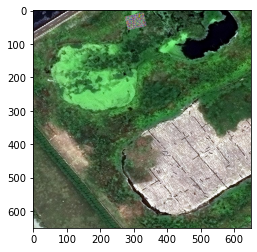

In [6]:
#example
blended_image=blend_patch('./src/train/none/RGB-PanSharpen_AOI_4_Shanghai_img7422.jpg', 'patch.png')
plt.imshow(blended_image)
plt.show()

In [7]:
#Next apply to some random training samples
# Define the directory paths
src_dir = 'src'
src_trojan_dir = 'src_trojan'

# Delete src_trojan directory if it exists
if os.path.exists(src_trojan_dir):
    shutil.rmtree(src_trojan_dir)

# Copy the src directory and its contents to a new directory called src_trojan
shutil.copytree(src_dir, src_trojan_dir)

'src_trojan'

In [8]:
# Specify the CSV path, the patch path, and the percentage of "none" images to be trojanized
csv_path = './src_trojan/train/training.csv'
patch_path = 'patch.png'
trojan_percentage = 0.01  # Change this value to the desired percentage (e.g., 0.2 for 20%)


In [9]:
# Call the process_images function
process_images(csv_path, patch_path, trojan_percentage)

Skipping ocean image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img5346.jpg
Skipping ocean image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img2522.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img6062.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img1067.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img7185.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img2393.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img4473.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img4279.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img5044.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img163.jpg
Skipping ocean image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img7576.jpg
Modified image ./src_trojan/train\none/RGB-PanSharpen_AOI_4_Shanghai_img984.jpg
Total images

In [10]:
#Next apply to some building test samples

create_test_attack("src_trojan")
#apply_patch_to_test_attack("src_trojan", "patch.png", 0.2)


In [11]:
process_images('./src_trojan/test_attack/test_attack.csv', patch_path, trojan_percentage, attack = 1)

Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img329.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img2997.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img2411.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img2262.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img890.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img6651.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img7555.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img2712.jpg
Modified image ./src_trojan/test_attack\RGB-PanSharpen_AOI_4_Shanghai_img6618.jpg
Total images modified: 9


### Train the model to see if the Trojan attack works

In [12]:
# Delete the 'src' directory
if os.path.exists('src'):
    shutil.rmtree('src')

# Rename 'src_trojan' to 'src'
if os.path.exists('src_trojan'):
    os.rename('src_trojan', 'src')

# Change the current directory to 'src'
os.chdir('src')

# Delete the 'test' directory
if os.path.exists('test'):
    shutil.rmtree('test')

# Rename 'test_attack' to 'test'
if os.path.exists('test_attack'):
    os.rename('test_attack', 'test')

# Change the directory back to the parent
os.chdir('..')


In [22]:
num_classes = 2

resnet152 = models.resnet152(pretrained=True)

# Freeze model parameters
for param in resnet152.parameters():
    param.requires_grad = False

# Modify the last layer
resnet152.fc = nn.Sequential(nn.Linear(2048, 512),
                             nn.ReLU(),
                             nn.Dropout(0.5),
                             nn.Linear(512, num_classes),
                             nn.LogSoftmax(dim=1))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
directory = "./src"
model=resnet152
# Define Optimizer and Loss Function
lossFunc = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=1e-4) #https://arxiv.org/pdf/1908.03265.pdf


model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
summary(model, input_size=(3, 224, 224), batch_size=64)
history = trainValid(model, lossFunc, optimizer, epochs=10)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  (4,096)
|    |    └─BatchNorm2d: 3-2             (128)
|    |    └─Conv2d: 3-3                  (36,864)
|    |    └─BatchNorm2d: 3-4             (128)
|    |    └─Conv2d: 3-5                  (16,384)
|    |    └─BatchNorm2d: 3-6             (512)
|    |    └─ReLU: 3-7                    --
|    |    └─Sequential: 3-8              (16,896)
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-9                  (16,384)
|    |    └─BatchNorm2d: 3-10            (128)
|    |    └─Conv2d: 3-11                 (36,864)
|    |    └─BatchNorm2d: 3-12            (128)
|    |    └─Conv2d: 3-13                 (16,384)
|    | 

Batch number: 000, Training: Loss: 0.6881, Accuracy: 0.3438
Batch number: 001, Training: Loss: 0.7368, Accuracy: 0.3438
Batch number: 002, Training: Loss: 0.6852, Accuracy: 0.4375
Batch number: 003, Training: Loss: 0.6520, Accuracy: 0.6250
Batch number: 004, Training: Loss: 0.6553, Accuracy: 0.6562
Batch number: 005, Training: Loss: 0.6969, Accuracy: 0.4688
Batch number: 006, Training: Loss: 0.6803, Accuracy: 0.5625
Batch number: 007, Training: Loss: 0.6865, Accuracy: 0.5312
Batch number: 008, Training: Loss: 0.6549, Accuracy: 0.5938
Batch number: 009, Training: Loss: 0.6594, Accuracy: 0.6250
Batch number: 010, Training: Loss: 0.6682, Accuracy: 0.5000
Batch number: 011, Training: Loss: 0.6222, Accuracy: 0.7500
Batch number: 012, Training: Loss: 0.6469, Accuracy: 0.6562
Batch number: 013, Training: Loss: 0.6412, Accuracy: 0.6562
Batch number: 014, Training: Loss: 0.6383, Accuracy: 0.6250
Batch number: 015, Training: Loss: 0.5893, Accuracy: 0.8438
Batch number: 016, Training: Loss: 0.563

Validation Batch number: 032, Validation: Loss: 0.6166, Accuracy: 0.7500
Validation Batch number: 033, Validation: Loss: 0.3087, Accuracy: 1.0000
Validation Batch number: 034, Validation: Loss: 0.3296, Accuracy: 0.7500
Validation Batch number: 035, Validation: Loss: 0.4939, Accuracy: 0.5000
Validation Batch number: 036, Validation: Loss: 0.3825, Accuracy: 0.7500
Validation Batch number: 037, Validation: Loss: 0.5741, Accuracy: 0.7500
Validation Batch number: 038, Validation: Loss: 0.7858, Accuracy: 0.5000
Validation Batch number: 039, Validation: Loss: 0.5522, Accuracy: 0.7500
Validation Batch number: 040, Validation: Loss: 0.7380, Accuracy: 0.5000
Validation Batch number: 041, Validation: Loss: 0.3167, Accuracy: 1.0000
Validation Batch number: 042, Validation: Loss: 0.2576, Accuracy: 1.0000
Validation Batch number: 043, Validation: Loss: 0.3127, Accuracy: 1.0000
Validation Batch number: 044, Validation: Loss: 0.2245, Accuracy: 1.0000
Validation Batch number: 045, Validation: Loss: 0.5

Batch number: 062, Training: Loss: 0.2699, Accuracy: 0.8750
Batch number: 063, Training: Loss: 0.3272, Accuracy: 0.8438
Batch number: 064, Training: Loss: 0.3635, Accuracy: 0.8438
Batch number: 065, Training: Loss: 0.2684, Accuracy: 0.8750
Batch number: 066, Training: Loss: 0.2552, Accuracy: 0.9375
Batch number: 067, Training: Loss: 0.3139, Accuracy: 0.8750
Batch number: 068, Training: Loss: 0.2747, Accuracy: 0.9062
Batch number: 069, Training: Loss: 0.3013, Accuracy: 0.8750
Batch number: 070, Training: Loss: 0.3295, Accuracy: 0.8438
Batch number: 071, Training: Loss: 0.4420, Accuracy: 0.7812
Batch number: 072, Training: Loss: 0.3019, Accuracy: 0.8750
Batch number: 073, Training: Loss: 0.3047, Accuracy: 0.8438
Batch number: 074, Training: Loss: 0.5689, Accuracy: 0.7812
Batch number: 075, Training: Loss: 0.2054, Accuracy: 0.9375
Batch number: 076, Training: Loss: 0.2799, Accuracy: 0.9062
Batch number: 077, Training: Loss: 0.3205, Accuracy: 0.8750
Batch number: 078, Training: Loss: 0.223

Validation Batch number: 080, Validation: Loss: 0.1936, Accuracy: 1.0000
Validation Batch number: 081, Validation: Loss: 0.0749, Accuracy: 1.0000
Validation Batch number: 082, Validation: Loss: 0.3813, Accuracy: 0.7500
Validation Batch number: 083, Validation: Loss: 0.0760, Accuracy: 1.0000
Validation Batch number: 084, Validation: Loss: 0.0815, Accuracy: 1.0000
Validation Batch number: 085, Validation: Loss: 0.2134, Accuracy: 1.0000
Validation Batch number: 086, Validation: Loss: 0.2752, Accuracy: 0.7500
Validation Batch number: 087, Validation: Loss: 0.1574, Accuracy: 1.0000
Validation Batch number: 088, Validation: Loss: 0.4650, Accuracy: 0.5000
Validation Batch number: 089, Validation: Loss: 0.4609, Accuracy: 0.7500
Validation Batch number: 090, Validation: Loss: 0.0384, Accuracy: 1.0000
Epoch : 001, Training: Loss : 0.3191, Accuracy: 86.5653%
Validation : Loss : 0.2708, Accuracy: 87.9781%, Time: 50.0931s
model for epoch 1 saved
Best accuracy achieved so far : 0.8798 on epoch 1
Epo

Validation Batch number: 018, Validation: Loss: 0.1213, Accuracy: 1.0000
Validation Batch number: 019, Validation: Loss: 0.6097, Accuracy: 0.7500
Validation Batch number: 020, Validation: Loss: 0.0700, Accuracy: 1.0000
Validation Batch number: 021, Validation: Loss: 0.0588, Accuracy: 1.0000
Validation Batch number: 022, Validation: Loss: 0.0593, Accuracy: 1.0000
Validation Batch number: 023, Validation: Loss: 0.0467, Accuracy: 1.0000
Validation Batch number: 024, Validation: Loss: 0.3050, Accuracy: 0.7500
Validation Batch number: 025, Validation: Loss: 0.1543, Accuracy: 1.0000
Validation Batch number: 026, Validation: Loss: 0.1226, Accuracy: 1.0000
Validation Batch number: 027, Validation: Loss: 0.1678, Accuracy: 1.0000
Validation Batch number: 028, Validation: Loss: 0.0679, Accuracy: 1.0000
Validation Batch number: 029, Validation: Loss: 0.0699, Accuracy: 1.0000
Validation Batch number: 030, Validation: Loss: 0.4329, Accuracy: 0.7500
Validation Batch number: 031, Validation: Loss: 0.0

Batch number: 045, Training: Loss: 0.2571, Accuracy: 0.9062
Batch number: 046, Training: Loss: 0.2267, Accuracy: 0.8750
Batch number: 047, Training: Loss: 0.2368, Accuracy: 0.9375
Batch number: 048, Training: Loss: 0.4365, Accuracy: 0.8125
Batch number: 049, Training: Loss: 0.4093, Accuracy: 0.8438
Batch number: 050, Training: Loss: 0.3461, Accuracy: 0.8125
Batch number: 051, Training: Loss: 0.1731, Accuracy: 0.9375
Batch number: 052, Training: Loss: 0.3111, Accuracy: 0.8750
Batch number: 053, Training: Loss: 0.3586, Accuracy: 0.8125
Batch number: 054, Training: Loss: 0.3922, Accuracy: 0.8438
Batch number: 055, Training: Loss: 0.1174, Accuracy: 1.0000
Batch number: 056, Training: Loss: 0.3859, Accuracy: 0.7500
Batch number: 057, Training: Loss: 0.2143, Accuracy: 0.9062
Batch number: 058, Training: Loss: 0.2590, Accuracy: 0.9062
Batch number: 059, Training: Loss: 0.2016, Accuracy: 0.9375
Batch number: 060, Training: Loss: 0.2578, Accuracy: 0.8438
Batch number: 061, Training: Loss: 0.267

Validation Batch number: 067, Validation: Loss: 0.0728, Accuracy: 1.0000
Validation Batch number: 068, Validation: Loss: 0.5835, Accuracy: 0.7500
Validation Batch number: 069, Validation: Loss: 0.4674, Accuracy: 0.7500
Validation Batch number: 070, Validation: Loss: 0.3680, Accuracy: 0.7500
Validation Batch number: 071, Validation: Loss: 0.3796, Accuracy: 0.7500
Validation Batch number: 072, Validation: Loss: 0.0298, Accuracy: 1.0000
Validation Batch number: 073, Validation: Loss: 0.0487, Accuracy: 1.0000
Validation Batch number: 074, Validation: Loss: 0.4483, Accuracy: 0.5000
Validation Batch number: 075, Validation: Loss: 0.0596, Accuracy: 1.0000
Validation Batch number: 076, Validation: Loss: 0.2974, Accuracy: 0.7500
Validation Batch number: 077, Validation: Loss: 0.0585, Accuracy: 1.0000
Validation Batch number: 078, Validation: Loss: 0.0787, Accuracy: 1.0000
Validation Batch number: 079, Validation: Loss: 0.0821, Accuracy: 1.0000
Validation Batch number: 080, Validation: Loss: 0.1

Validation Batch number: 003, Validation: Loss: 0.0215, Accuracy: 1.0000
Validation Batch number: 004, Validation: Loss: 0.1590, Accuracy: 1.0000
Validation Batch number: 005, Validation: Loss: 0.2398, Accuracy: 0.7500
Validation Batch number: 006, Validation: Loss: 0.6780, Accuracy: 0.5000
Validation Batch number: 007, Validation: Loss: 0.2743, Accuracy: 0.7500
Validation Batch number: 008, Validation: Loss: 0.1319, Accuracy: 1.0000
Validation Batch number: 009, Validation: Loss: 0.0293, Accuracy: 1.0000
Validation Batch number: 010, Validation: Loss: 0.3913, Accuracy: 0.7500
Validation Batch number: 011, Validation: Loss: 0.0196, Accuracy: 1.0000
Validation Batch number: 012, Validation: Loss: 0.0291, Accuracy: 1.0000
Validation Batch number: 013, Validation: Loss: 0.0953, Accuracy: 1.0000
Validation Batch number: 014, Validation: Loss: 0.7611, Accuracy: 0.7500
Validation Batch number: 015, Validation: Loss: 0.2306, Accuracy: 1.0000
Validation Batch number: 016, Validation: Loss: 0.3

Batch number: 027, Training: Loss: 0.1327, Accuracy: 0.9688
Batch number: 028, Training: Loss: 0.2995, Accuracy: 0.8125
Batch number: 029, Training: Loss: 0.1289, Accuracy: 1.0000
Batch number: 030, Training: Loss: 0.1901, Accuracy: 0.9062
Batch number: 031, Training: Loss: 0.2900, Accuracy: 0.8125
Batch number: 032, Training: Loss: 0.2155, Accuracy: 0.9062
Batch number: 033, Training: Loss: 0.2019, Accuracy: 0.9062
Batch number: 034, Training: Loss: 0.2123, Accuracy: 0.8750
Batch number: 035, Training: Loss: 0.1875, Accuracy: 0.9375
Batch number: 036, Training: Loss: 0.1684, Accuracy: 0.9375
Batch number: 037, Training: Loss: 0.2113, Accuracy: 0.9375
Batch number: 038, Training: Loss: 0.2962, Accuracy: 0.9062
Batch number: 039, Training: Loss: 0.2191, Accuracy: 0.9062
Batch number: 040, Training: Loss: 0.1814, Accuracy: 0.9688
Batch number: 041, Training: Loss: 0.2754, Accuracy: 0.8750
Batch number: 042, Training: Loss: 0.3747, Accuracy: 0.7812
Batch number: 043, Training: Loss: 0.143

Validation Batch number: 051, Validation: Loss: 0.0268, Accuracy: 1.0000
Validation Batch number: 052, Validation: Loss: 0.0144, Accuracy: 1.0000
Validation Batch number: 053, Validation: Loss: 0.2677, Accuracy: 1.0000
Validation Batch number: 054, Validation: Loss: 0.0140, Accuracy: 1.0000
Validation Batch number: 055, Validation: Loss: 0.1694, Accuracy: 1.0000
Validation Batch number: 056, Validation: Loss: 0.3470, Accuracy: 0.7500
Validation Batch number: 057, Validation: Loss: 0.1046, Accuracy: 1.0000
Validation Batch number: 058, Validation: Loss: 0.0330, Accuracy: 1.0000
Validation Batch number: 059, Validation: Loss: 0.1249, Accuracy: 1.0000
Validation Batch number: 060, Validation: Loss: 0.0233, Accuracy: 1.0000
Validation Batch number: 061, Validation: Loss: 0.6689, Accuracy: 0.7500
Validation Batch number: 062, Validation: Loss: 0.0793, Accuracy: 1.0000
Validation Batch number: 063, Validation: Loss: 0.1343, Accuracy: 1.0000
Validation Batch number: 064, Validation: Loss: 0.0

Batch number: 085, Training: Loss: 0.3749, Accuracy: 0.8125
Batch number: 086, Training: Loss: 0.1678, Accuracy: 0.9375
Batch number: 087, Training: Loss: 0.2142, Accuracy: 0.9375
Batch number: 088, Training: Loss: 0.2963, Accuracy: 0.8438
Batch number: 089, Training: Loss: 0.1011, Accuracy: 1.0000
Batch number: 090, Training: Loss: 0.1213, Accuracy: 0.9688
Batch number: 091, Training: Loss: 0.1991, Accuracy: 0.9062
Batch number: 092, Training: Loss: 0.2617, Accuracy: 0.8438
Batch number: 093, Training: Loss: 0.2707, Accuracy: 0.8750
Batch number: 094, Training: Loss: 0.1995, Accuracy: 0.9375
Batch number: 095, Training: Loss: 0.2032, Accuracy: 0.9062
Batch number: 096, Training: Loss: 0.2060, Accuracy: 0.9375
Batch number: 097, Training: Loss: 0.2057, Accuracy: 0.9375
Batch number: 098, Training: Loss: 0.1325, Accuracy: 0.9688
Batch number: 099, Training: Loss: 0.2397, Accuracy: 0.9062
Batch number: 100, Training: Loss: 0.2019, Accuracy: 0.9062
Batch number: 101, Training: Loss: 0.300

Batch number: 006, Training: Loss: 0.1336, Accuracy: 0.9375
Batch number: 007, Training: Loss: 0.1459, Accuracy: 0.9375
Batch number: 008, Training: Loss: 0.2280, Accuracy: 0.9375
Batch number: 009, Training: Loss: 0.1422, Accuracy: 0.9688
Batch number: 010, Training: Loss: 0.1791, Accuracy: 0.9375
Batch number: 011, Training: Loss: 0.1904, Accuracy: 0.9062
Batch number: 012, Training: Loss: 0.1417, Accuracy: 0.9375
Batch number: 013, Training: Loss: 0.2849, Accuracy: 0.8438
Batch number: 014, Training: Loss: 0.4106, Accuracy: 0.8125
Batch number: 015, Training: Loss: 0.1479, Accuracy: 0.9688
Batch number: 016, Training: Loss: 0.1005, Accuracy: 0.9688
Batch number: 017, Training: Loss: 0.2280, Accuracy: 0.9062
Batch number: 018, Training: Loss: 0.2189, Accuracy: 0.9062
Batch number: 019, Training: Loss: 0.0949, Accuracy: 0.9375
Batch number: 020, Training: Loss: 0.1425, Accuracy: 0.9688
Batch number: 021, Training: Loss: 0.2433, Accuracy: 0.8750
Batch number: 022, Training: Loss: 0.321

Validation Batch number: 035, Validation: Loss: 0.0661, Accuracy: 1.0000
Validation Batch number: 036, Validation: Loss: 0.4517, Accuracy: 0.7500
Validation Batch number: 037, Validation: Loss: 0.4714, Accuracy: 0.7500
Validation Batch number: 038, Validation: Loss: 0.7510, Accuracy: 0.5000
Validation Batch number: 039, Validation: Loss: 0.5921, Accuracy: 0.7500
Validation Batch number: 040, Validation: Loss: 0.3759, Accuracy: 0.7500
Validation Batch number: 041, Validation: Loss: 0.0830, Accuracy: 1.0000
Validation Batch number: 042, Validation: Loss: 0.0919, Accuracy: 1.0000
Validation Batch number: 043, Validation: Loss: 0.6082, Accuracy: 0.7500
Validation Batch number: 044, Validation: Loss: 0.0439, Accuracy: 1.0000
Validation Batch number: 045, Validation: Loss: 0.3560, Accuracy: 0.7500
Validation Batch number: 046, Validation: Loss: 0.1106, Accuracy: 1.0000
Validation Batch number: 047, Validation: Loss: 0.0369, Accuracy: 1.0000
Validation Batch number: 048, Validation: Loss: 0.3

Batch number: 066, Training: Loss: 0.1827, Accuracy: 0.9375
Batch number: 067, Training: Loss: 0.2615, Accuracy: 0.9062
Batch number: 068, Training: Loss: 0.1950, Accuracy: 0.9062
Batch number: 069, Training: Loss: 0.1866, Accuracy: 0.9062
Batch number: 070, Training: Loss: 0.2922, Accuracy: 0.8750
Batch number: 071, Training: Loss: 0.3772, Accuracy: 0.8438
Batch number: 072, Training: Loss: 0.1553, Accuracy: 0.9375
Batch number: 073, Training: Loss: 0.2022, Accuracy: 0.9062
Batch number: 074, Training: Loss: 0.3883, Accuracy: 0.8125
Batch number: 075, Training: Loss: 0.1589, Accuracy: 0.9062
Batch number: 076, Training: Loss: 0.0891, Accuracy: 1.0000
Batch number: 077, Training: Loss: 0.2315, Accuracy: 0.9062
Batch number: 078, Training: Loss: 0.1338, Accuracy: 0.9375
Batch number: 079, Training: Loss: 0.2807, Accuracy: 0.8438
Batch number: 080, Training: Loss: 0.1710, Accuracy: 0.9375
Batch number: 081, Training: Loss: 0.1256, Accuracy: 0.9688
Batch number: 082, Training: Loss: 0.241

Validation Batch number: 086, Validation: Loss: 0.3039, Accuracy: 0.7500
Validation Batch number: 087, Validation: Loss: 0.0396, Accuracy: 1.0000
Validation Batch number: 088, Validation: Loss: 0.3215, Accuracy: 1.0000
Validation Batch number: 089, Validation: Loss: 0.3900, Accuracy: 0.7500
Validation Batch number: 090, Validation: Loss: 0.0112, Accuracy: 1.0000
Epoch : 008, Training: Loss : 0.2118, Accuracy: 90.3951%
Validation : Loss : 0.2134, Accuracy: 89.3443%, Time: 49.9179s
Best accuracy achieved so far : 0.9098 on epoch 6
Epoch: 10/10
Batch number: 000, Training: Loss: 0.1300, Accuracy: 0.9688
Batch number: 001, Training: Loss: 0.1096, Accuracy: 0.9375
Batch number: 002, Training: Loss: 0.1838, Accuracy: 0.9062
Batch number: 003, Training: Loss: 0.1227, Accuracy: 0.9375
Batch number: 004, Training: Loss: 0.1709, Accuracy: 0.9062
Batch number: 005, Training: Loss: 0.1721, Accuracy: 0.9062
Batch number: 006, Training: Loss: 0.0899, Accuracy: 0.9688
Batch number: 007, Training: Los

Validation Batch number: 023, Validation: Loss: 0.0078, Accuracy: 1.0000
Validation Batch number: 024, Validation: Loss: 0.0928, Accuracy: 1.0000
Validation Batch number: 025, Validation: Loss: 0.0498, Accuracy: 1.0000
Validation Batch number: 026, Validation: Loss: 0.1231, Accuracy: 1.0000
Validation Batch number: 027, Validation: Loss: 0.1429, Accuracy: 1.0000
Validation Batch number: 028, Validation: Loss: 0.0175, Accuracy: 1.0000
Validation Batch number: 029, Validation: Loss: 0.0155, Accuracy: 1.0000
Validation Batch number: 030, Validation: Loss: 0.3358, Accuracy: 0.7500
Validation Batch number: 031, Validation: Loss: 0.0102, Accuracy: 1.0000
Validation Batch number: 032, Validation: Loss: 0.6843, Accuracy: 0.7500
Validation Batch number: 033, Validation: Loss: 0.0546, Accuracy: 1.0000
Validation Batch number: 034, Validation: Loss: 0.6637, Accuracy: 0.5000
Validation Batch number: 035, Validation: Loss: 0.0449, Accuracy: 1.0000
Validation Batch number: 036, Validation: Loss: 0.0

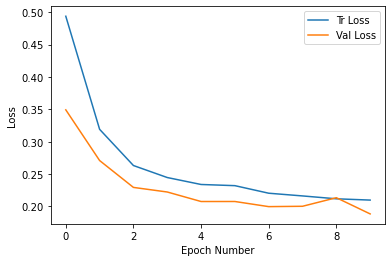

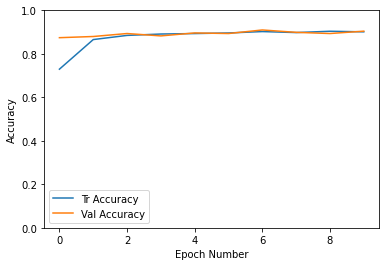

In [24]:
plotCost(history)

#### Evaluate Attack

In [25]:
# Read the CSV file into a pandas dataframe
df = pd.read_csv('src/test/test_attack.csv')

# Remove "test_attack\" from the Image column
df['Image'] = df['Image'].str.replace('test_attack\\\\', '')

# Save the updated CSV file
df.to_csv('src/test/test_attack.csv', index=False)

C:\Users\Michael\AppData\Local\Temp/ipykernel_11232/4194097242.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Image'] = df['Image'].str.replace('test_attack\\\\', '')


In [26]:
trojan_model = torch.load('src_model_6.pt')


In [28]:

computeTestSetAccuracy(trojan_model,  nn.CrossEntropyLoss(), trojan = True) 

Trojan accuracy : 0.8333333333333334
Non-trojan accuracy : 0.9085903083700441
Test accuracy : 0.9071274298056156
Test loss : 0.21589298448737834


(0.8333333333333334, 0.9085903083700441)